# Identify specific populations and expand these masks - Single object


By employing the CosMx data, we sought to identify gamma delta (γδ) T cells, a rare immune cell subset that is otherwise difficult to detect through clustering and phenotyping of segmented cells 

To achieve this, we applied GRIDGEN’s convolutional approach to identify putative regions enriched for γδ T cell transcripts. Specifically, we identified areas where TRGC and TRDC transcripts, encoding for the T cell receptor (TCR) constant regions of γδ T cells, were within 5.5 µm of each other, with contours highlighting these regions. Beyond the presence of TRGC and TRDC transcripts in a confined area, specific criteria were applied, including thresholds on transcript counts, contour size, and transcript combinations, specifically requiring the sum of TRGC and TRDC counts to be higher than the sum of TRAC and TRBC (encoding for the TCR of γδ T cells), with at least one TRGC and one TRDC . 

The resulting regions represent putative γδ T cell areas that can be subjected to further analysis. 

In [1]:
%load_ext autoreload

import os 
import sys
import time
import logging
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json

from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from PIL import Image, ImageDraw
import json
import math
import matplotlib.patches as mpatches
import matplotlib.patches as patches
from skimage.measure import label

sys.path.append(os.path.dirname(os.getcwd()))
from gridgen import get_arrays as ga
from gridgen import contours, get_masks 
from gridgen.mask_properties import MaskAnalysisPipeline, MaskDefinition
from gridgen.get_masks import MultiClassObjectAnalysis

from helper_plot import plot_TRGC_TRDC_points_polygons, plot_TRGC_TRDC_points_contours, plot_TRGC_TRDC_points_mask

define looger -- important to save info of the runs 

In [2]:
# define the logger :  can be None, and is set to INFO
# Custom logger setup
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

define files

In [3]:
cosmx_path_s3 =  '../../cosmx_data/S3/S3/20230628_151317_S3/AnalysisResults/yxyz3r7ufm'

folder_names_s3 = [folder_name for folder_name in os.listdir(cosmx_path_s3) if
                os.path.isdir(os.path.join(cosmx_path_s3, folder_name))]


target_files_s3 = [
    os.path.join(cosmx_path_s3, folder, file)
    for folder in os.listdir(cosmx_path_s3)
    if os.path.isdir(os.path.join(cosmx_path_s3, folder))
    for file in os.listdir(os.path.join(cosmx_path_s3, folder))
    if '__target_call_coord.csv' in file
]

files_cosmx = natsorted(target_files_s3)
len(files_cosmx)

dapi_folder = '/home/martinha/PycharmProjects/phd/spatial_transcriptomics/cosmx_data/S3/S3/20230628_151317_S3/CellStatsDir/Morphology2D/'
annotation_cellpose = '/home/martinha/PycharmProjects/phd/spatial_transcriptomics/cosmx_data/S3/Slide4_S3_CosMx_CellPose_All_annotated.csv'


annotation_df = pd.read_csv(annotation_cellpose)
print(annotation_df['Final_label'].value_counts())
print(len(annotation_df))

Final_label
Epithelial cells     20558
T cells               9436
Myeloid cells         6688
Fibroblasts           6133
Other cells           4988
Plasma cells          1656
Endothelial cells     1508
Name: count, dtype: int64
50967


***2. Define GD***

This intends to, based on defined genes, find γδ T cells.

We need to define: 

1. Parameters for γδ contours
    * Genes to consider
    * density
    * minimum area
    * kernel size
    
    this will define for an overlapping area with **kernel size** a minimum number of **density** **genes of interest**. The contiguous area of the contour will have at least **minimum area**. 
 
2. You may also need to define extra parameters to filter out wrong contours   

Define arrays for an example FOV

In [4]:
target_gd = ['TRGC1/TRGC2', 'TRDC']
target_ab = ['TRBC1/TRBC2', 'TRAC']

target_cd8 = ['CD8A','CD8B', 'TRBC1/TRBC2', 'TRAC']
target_cd4 = ['CD4']

target_tum = ['EPCAM', 'CEACAM6', 'CLDN4', 'CDH1', 'RNF43', 'SPINK1', 'SOX9', 'CD24', 'KRT19', 'AREG',
              'REG1A', 'AGR2', 'PLAC8', 'CALB1', 'S100P', 'ITGA6', 'DMBT1', 'DUSP4',
              'KRT8', 'S100A6', 'RPL37', 'RPL32', 'KRT18', 'OLFM4',
              'PRSS2', 'CD55', 'EPHB4', 'ADGRL1', 'KRT17', 'ITGB8', 'ADGRE5', 'GDF15', 'IL27RA', 'AZGP1'
              ]  # cadherin 'PIGR',  'LYZ','SERPINA1'

In [5]:
fov = 'FOV007'
file_csv = [file for file in files_cosmx if fov in file][0]  
    
df_total = pd.read_csv(file_csv)
df_total = df_total.rename(columns={'x': 'X', 'y': 'Y'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

print(f'n genes: {n_genes}')
print(f'shape: {height}, {width}')
print(f'n hits {len(df_total)}')

target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_gd, array_subset_gd, target_indices_subset_gd = ga.get_subset_arrays(df_total, array_total,
                                                                                   target_dict_total,
                                                                                   target_list=target_gd,
                                                                           target_col='target')

df_subset_ab, array_subset_ab, target_indices_subset_ab = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=target_ab,
                                                                                       target_col='target')
    
    
df_subset_g, array_subset_g, target_indices_subset_g = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRGC1/TRGC2'],
                                                                                       target_col='target')
    
df_subset_d, array_subset_d, target_indices_subset_d = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRDC'],
                                                                                       target_col='target')


df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                         target_list=target_tum, target_col = 'target')


df_subset_cd8, array_subset_cd8, target_indices_subset_cd8 = ga.get_subset_arrays(df_total, array_total,
                                                                                      target_dict_total,
                                                                                      target_list=target_cd8,
                                                                                      target_col='target')
                                                                               

df_subset_TRAC_gene, array_subset_TRAC_gene, target_indices_subset_TRAC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRAC'],
                                                                                      target_col='target')

df_subset_TRBC_gene, array_subset_TRBC_gene, target_indices_subset_TRBC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRBC1/TRBC2'],
                                                                                      target_col='target')


df_subset_cd8_gene, array_subset_cd8_gene, target_indices_subset_cd8_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD8A', 'CD8B'],
                                                                                      target_col='target')

df_subset_cd4_gene, array_subset_cd4_gene, target_indices_subset_cd4_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD4'],
                                                                                      target_col='target')

n genes: 999
shape: 4246, 4245
n hits 2838781


T cells are usually between 5-10 um diameter, in CosMx this will be between 43 px and 85 px. 
We will find regions possible with γδ using the convolution approach.

In [6]:
density_th_gd = 2
min_area_th_gd = 5  # 40
kernel_size_gd = 45 #90 

2025-06-16 13:01:14,484 - contour_logger - INFO - Initialized GetContour


get_conv_sum took 0.4380 seconds


2025-06-16 13:01:15,160 - contour_logger - INFO - Number of contours after filtering no counts: 46


contours_from_sum took 0.2381 seconds


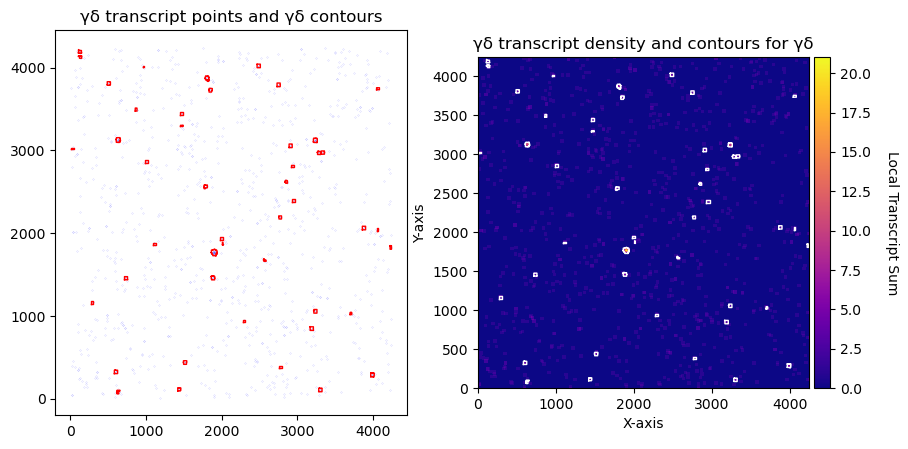

total contours found  0
total contours after filtering by area 0


In [7]:
CGD = contours.ConvolutionContours(array_subset_gd, contour_name='GD', logger=logger)
CGD.get_conv_sum(kernel_size=kernel_size_gd, kernel_shape='square')  #
CGD.contours_from_sum(density_threshold=density_th_gd,
                      min_area_threshold=min_area_th_gd, directionality='higher')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

CGD.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                              c_points='blue', c_contours='red', ax=axs[0])
axs[0].set_title('γδ transcript points and γδ contours')

CGD.plot_conv_sum(cmap='plasma', c_countour='white', path=None, ax=axs[1])
axs[1].set_title('γδ transcript density and contours for γδ')

plt.show()


print('total contours found ', CGD.total_valid_contours)
print('total contours after filtering by area', CGD.contours_filtered_area)

In this case, we are considering a possible object of γδ T cells (one or more) if there is at least 3 counts (>2) of the genes ['TRGC1','TRGC2','TRDC'] in a kernel size 45*45.

This is a very lenient threshold. One could use more stringent thresholds but risk to possible loose some cells. One shoudl design these parameters accordingly to the genes behaviour. γδ transcripts in CosMx are not express much.

As we are using light restrictions, some of the contours are not true γδ cells. For example, an artifact cluster of 3 TRGC1 genes would be considered. Also, in biological terms, it is necessary to also guarantee that the TRGC and TRDC are more expressed than the receptors B and C of other T cells.

We will define some filtering rules:

        * AB < GD :  counts of AB total counts in the contour needs to be lower than tota GD point counts. 
        * The contour should have at least 1 count of G and one count of D. G >0, D>0.
        
        
filter_contours_by_gene_comparison ->   Filters contours based on the comparison of gene counts between two gene arrays.Contours are kept if the gene count in `gene_array1` is greater than the gene count in `gene_array2` (`gene_array1`>`gene_array2`) 

filter_contours_by_gene_threshold -> Filters contours based on a gene count threshold. Contours are kept if the gene count is greater than or equal to the threshold (`gene_array`>=threshold). 


In [8]:
### Filtering 
CGD.filter_contours_by_gene_comparison(gene_array1 = array_subset_gd, gene_array2 = array_subset_ab,
                                       gene_name1 = "gd", gene_name2 = "ab") # gene 1 > gene2 --> valid contour 
# G>0 D>0
CGD.filter_contours_by_gene_threshold(gene_array = array_subset_d.squeeze(), threshold = 1, gene_name = 'TRDC')# >= 1
CGD.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_g, axis=-1), threshold = 1, gene_name = 'TRGC1_2')# >= 1
print('total contours found ', len(CGD.contours))

2025-06-16 13:01:18,454 - contour_logger - INFO - Excluding contour 21. gd count 3.00 ≤ ab count 5.00
2025-06-16 13:01:19,977 - contour_logger - INFO - Excluding contour 44. gd count 3.00 ≤ ab count 3.00
2025-06-16 13:01:20,046 - contour_logger - INFO - Excluding contour 45. gd count 1.00 ≤ ab count 1.00
2025-06-16 13:01:20,046 - contour_logger - INFO - Contours remaining after gene comparison: 43
2025-06-16 13:01:20,081 - contour_logger - INFO - Excluding contour 0. Gene TRDC count  0.0 is below threshold 1
2025-06-16 13:01:20,215 - contour_logger - INFO - Excluding contour 4. Gene TRDC count  0.0 is below threshold 1
2025-06-16 13:01:20,284 - contour_logger - INFO - Excluding contour 6. Gene TRDC count  0.0 is below threshold 1
2025-06-16 13:01:20,452 - contour_logger - INFO - Excluding contour 11. Gene TRDC count  0.0 is below threshold 1
2025-06-16 13:01:20,620 - contour_logger - INFO - Excluding contour 16. Gene TRDC count  0.0 is below threshold 1
2025-06-16 13:01:21,095 - contou

total contours found  13


Lets plot the transcripts on top of DAPI images for better visuaization. 

In [9]:
%%time
# # plot polygons with TRDC and TRGC points for cell boundaries
# img_points_dapi = plot_TRGC_TRDC_points_mask(segmentation_file_path, filtered_data_gd,dapi_file_path, figsize=(10, 10))
df_total = pd.read_csv(file_csv)
target_list = ['TRGC1/TRGC2', 'TRDC','TRBC1/TRBC2', ] # 'TRAC', 'CD8A', 'CD8B', 'CD4'
filtered_data_gd = df_total[df_total['target'].isin(target_list)]

dapi_file = [file for file in os.listdir(dapi_folder) if str(fov[3:]) in file][0]
dapi_file_path = os.path.join(dapi_folder, dapi_file)

img_gd_contour = plot_TRGC_TRDC_points_contours(CGD.contours, filtered_data_gd, dapi_file_path)

# GM = get_masks.GetMasks(image_shape=(height, width))

# SA = get_masks.SingleClassObjectAnalysis(GM,contours_object=CGD.contours)
# SA.get_mask_objects(exclude_masks=None)  # Not excluding any tum or empty 

# SA.get_objects_expansion(expansions_pixels=[10, 20, 30],
#                          exclude_masks=None)  # exclude from empty? or from tumour? Not excluding
# mask_GD = SA.mask_object_SA
# morpho_properties= MorphologyExtractor().extract_per_object_features(labeled_mask= label(mask_GD))
# centroids = [(obj['centroid_x'], obj['centroid_y']) for obj in morpho_properties]
# print('gd', centroids)

<built-in method max of numpy.ndarray object at 0x7fbf00d5bc90>
CPU times: user 3.63 s, sys: 357 ms, total: 3.99 s
Wall time: 4.04 s


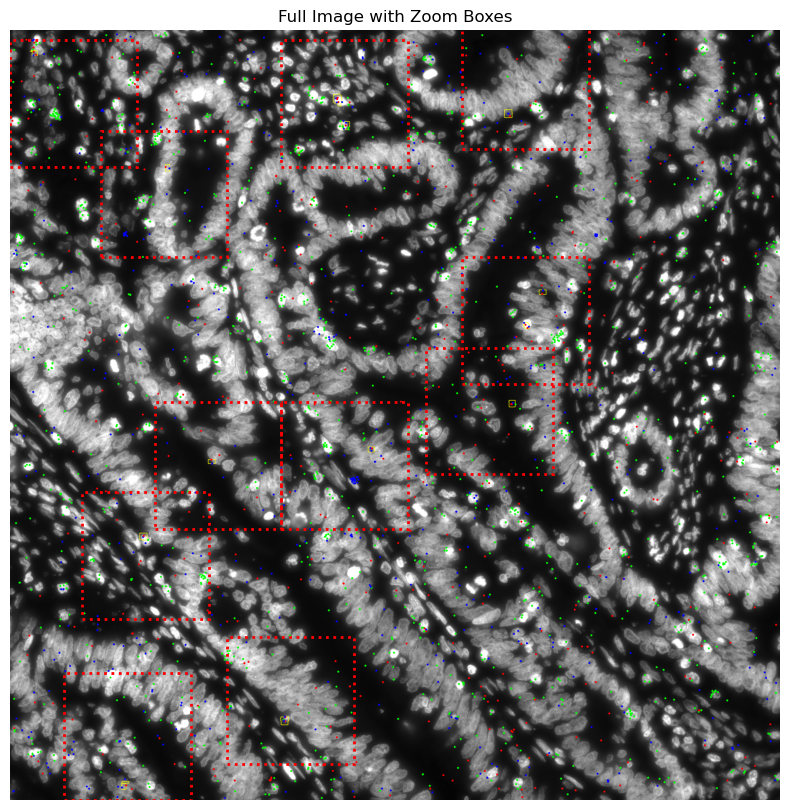

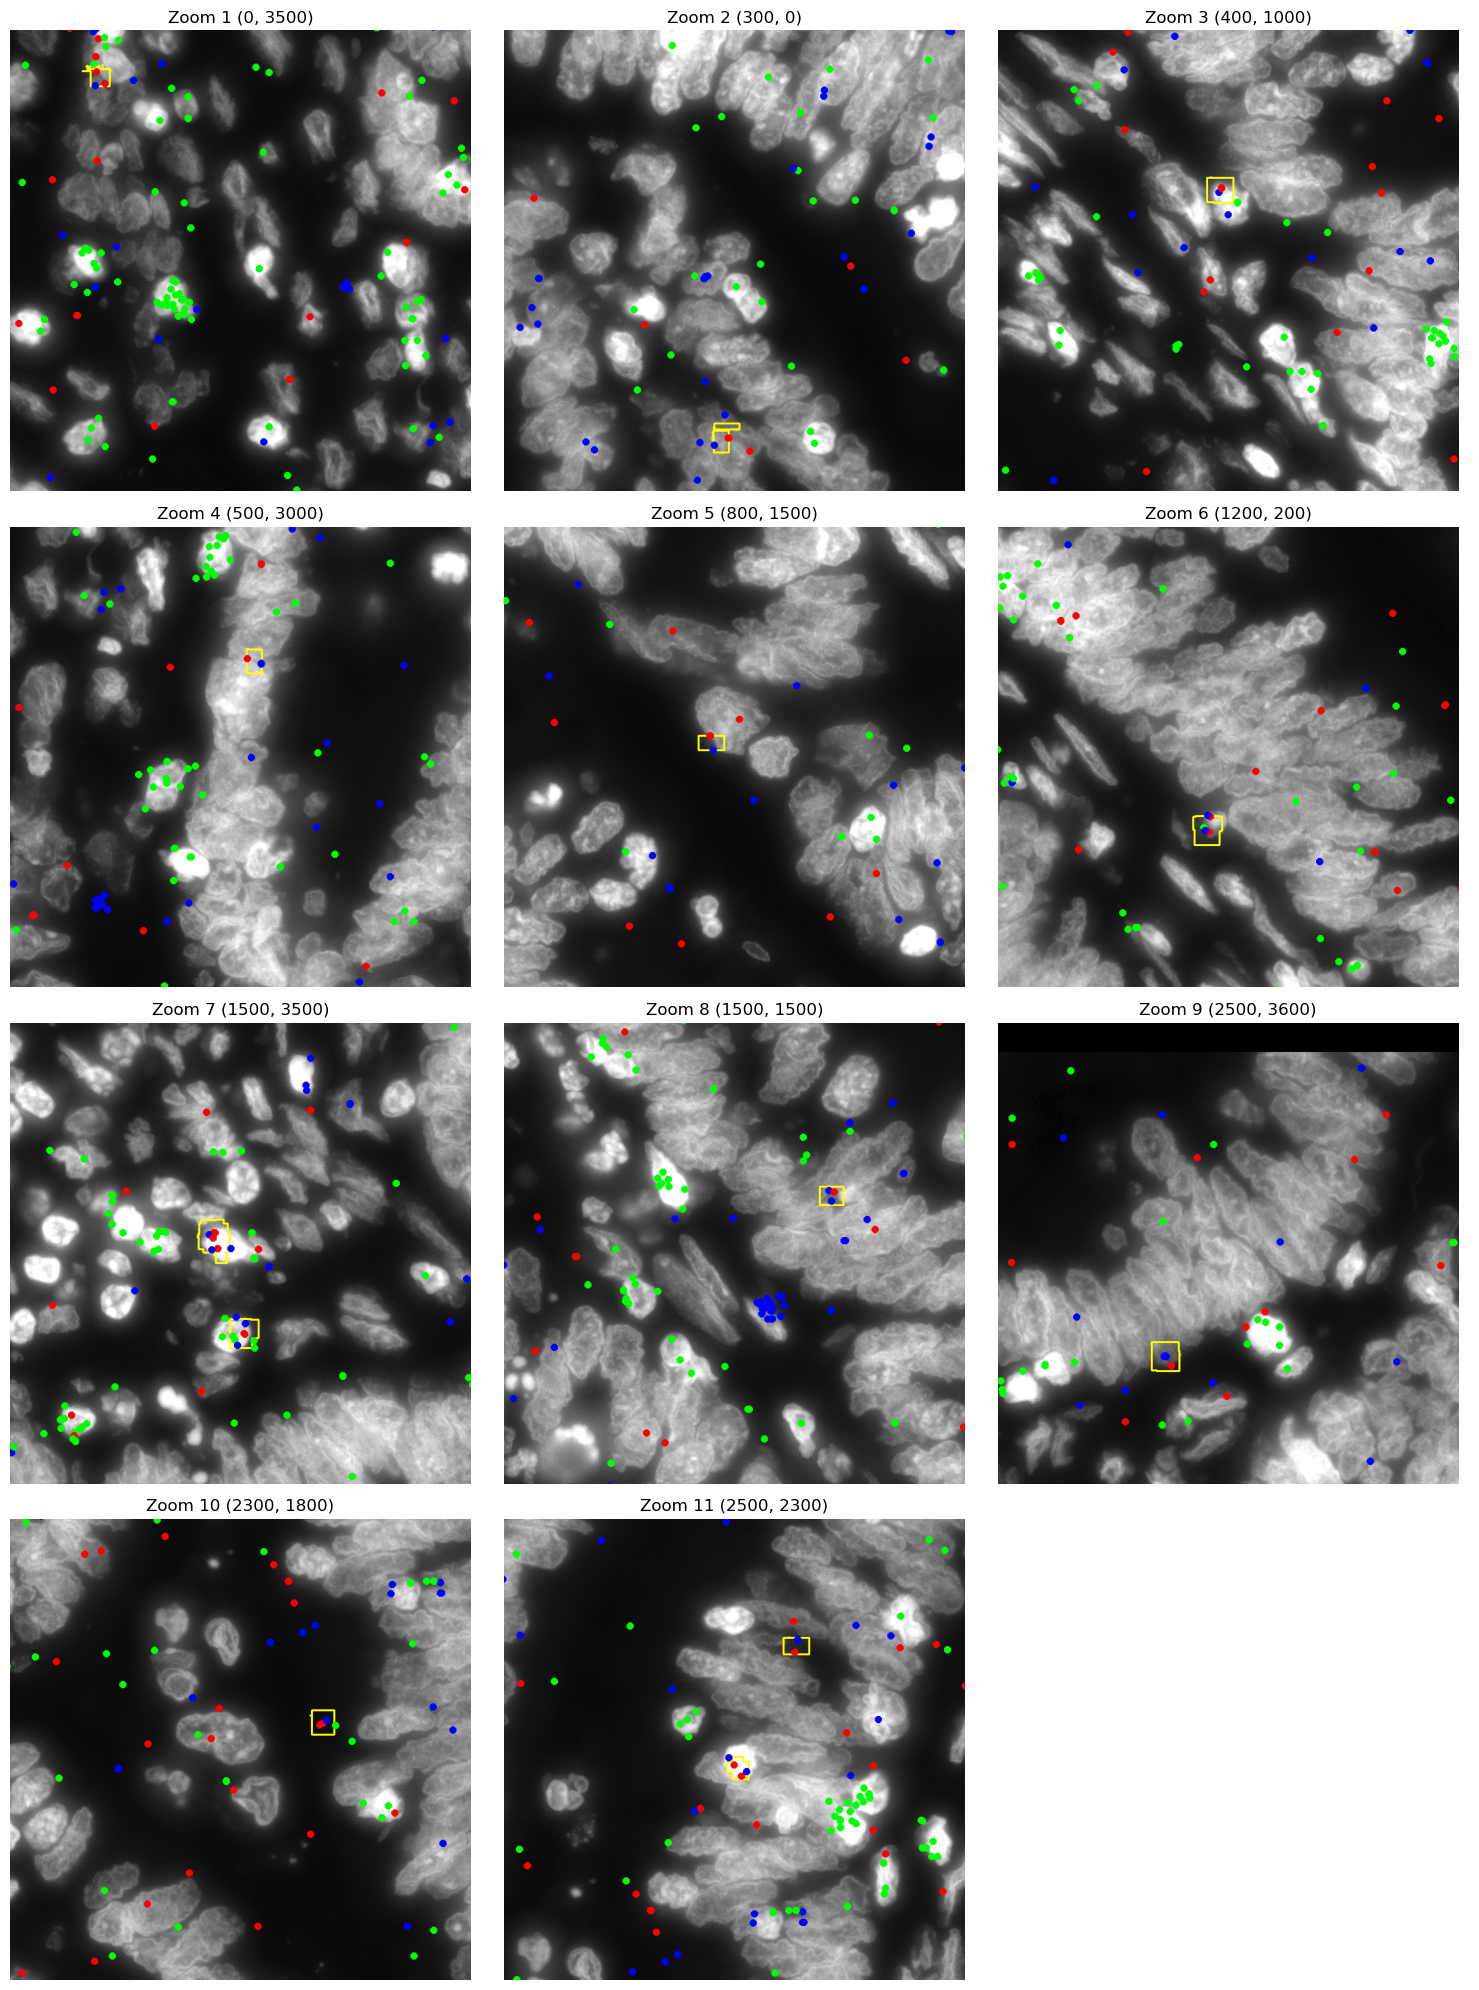

In [10]:
zoom_coords_fov7 = [
   (0,3500),  # (135.67423382519863, 4128.138479001135),
   (300,0), #(631.9569805194806, 81.96996753246754),
 (400,1000), #(737.3119551681195, 1455.9663760896638),
 (500,3000), #(870.4814814814815, 3494.063973063973),
 (800,1500), #(1114.5, 1870.0),
 (1200,200), #(1517.5759023354565, 437.6995753715499),
 (1500,3500), #(1810.3046566692976, 3871.5994475138123),
 (1500,1500), #(1997.0, 1937.0),
 (2500,3600), #(2753.920020909566, 3792.991113434396),
 (2300,1800), #(2774.9572393098274, 2190.523630907727),
 (2500,2300), #(2855.645518630413, 2620.5387713997984),
]
    
zoom_coords = zoom_coords_fov7  # your list of (x, y) points
zoom_size = 700  # size of the square to crop

# Plot full image with red rectangles ===
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_gd_contour, origin='lower')
ax.axis('off')
ax.set_title("Full Image with Zoom Boxes")

# Add red dotted rectangles
for zoom_x, zoom_y in zoom_coords:
    rect = patches.Rectangle(
        (zoom_x, zoom_y),
        zoom_size,
        zoom_size,
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        linestyle='dotted'
    )
    ax.add_patch(rect)

plt.show()

# Plot zoomed-in regions in a grid with 3 columns ===
num_coords = len(zoom_coords)
num_cols = 3
num_rows = (num_coords + num_cols - 1) // num_cols  # ceil division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

# If axes is 1D (single row), make it 2D for uniformity
if num_rows == 1:
    axes = [axes]

for idx, (zoom_x, zoom_y) in enumerate(zoom_coords):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row][col] if num_rows > 1 else axes[col]

    # Define bounding box for cropping
    box = (zoom_x, zoom_y, zoom_x + zoom_size, zoom_y + zoom_size)
    cropped_img = img_gd_contour.crop(box)

    ax.imshow(cropped_img, origin='lower')
    ax.axis('off')
    ax.set_title(f"Zoom {idx + 1} ({zoom_x}, {zoom_y})")

# Hide any unused subplots
for idx in range(num_coords, num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row][col] if num_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()


2025-06-16 13:01:46,726 - contour_logger - INFO - Initialized GetContour


get_conv_sum took 0.4293 seconds


2025-06-16 13:01:47,365 - contour_logger - INFO - Number of contours after filtering no counts: 26


contours_from_sum took 0.2089 seconds


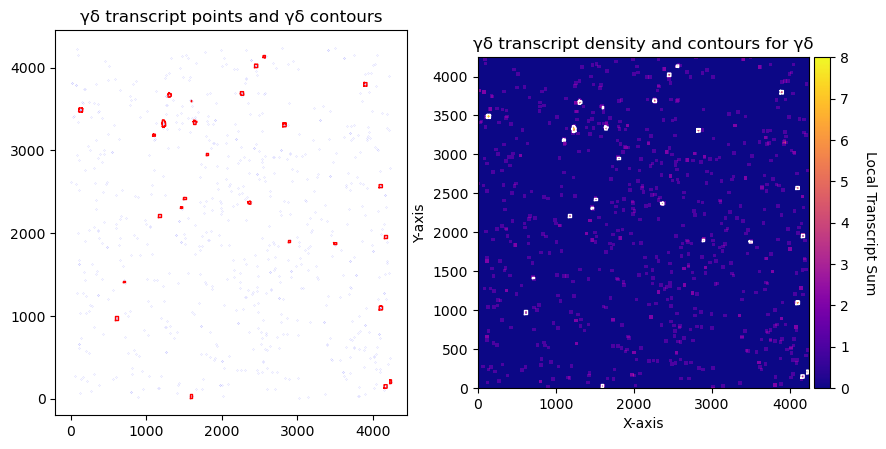

total contours found  0
total contours after filtering by area 0


2025-06-16 13:01:49,764 - contour_logger - INFO - Excluding contour 7. gd count 3.00 ≤ ab count 4.00
2025-06-16 13:01:50,173 - contour_logger - INFO - Excluding contour 13. gd count 1.00 ≤ ab count 2.00
2025-06-16 13:01:50,241 - contour_logger - INFO - Excluding contour 14. gd count 3.00 ≤ ab count 3.00
2025-06-16 13:01:50,977 - contour_logger - INFO - Contours remaining after gene comparison: 23
2025-06-16 13:01:51,036 - contour_logger - INFO - Excluding contour 1. Gene TRDC count  0.0 is below threshold 1
2025-06-16 13:01:51,065 - contour_logger - INFO - Excluding contour 2. Gene TRDC count  0.0 is below threshold 1
2025-06-16 13:01:51,409 - contour_logger - INFO - Excluding contour 14. Gene TRDC count  0.0 is below threshold 1
2025-06-16 13:01:51,637 - contour_logger - INFO - Excluding contour 22. Gene TRDC count  0.0 is below threshold 1
2025-06-16 13:01:51,638 - contour_logger - INFO - Number of contours remaining: 19
2025-06-16 13:01:51,767 - contour_logger - INFO - Excluding con

total contours found  8
<built-in method max of numpy.ndarray object at 0x7fbefef3e4f0>


In [11]:
fov = 'FOV010'
file_csv = [file for file in files_cosmx if fov in file][0]  
    
df_total = pd.read_csv(file_csv)
df_total = df_total.rename(columns={'x': 'X', 'y': 'Y'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_gd, array_subset_gd, target_indices_subset_gd = ga.get_subset_arrays(df_total, array_total,
                                                                                   target_dict_total,
                                                                                   target_list=target_gd,
                                                                           target_col='target')

df_subset_ab, array_subset_ab, target_indices_subset_ab = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=target_ab,
                                                                                       target_col='target')
    
    
df_subset_g, array_subset_g, target_indices_subset_g = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRGC1/TRGC2'],
                                                                                       target_col='target')
    
df_subset_d, array_subset_d, target_indices_subset_d = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRDC'],
                                                                                       target_col='target')


df_subset_cd8, array_subset_cd8, target_indices_subset_cd8 = ga.get_subset_arrays(df_total, array_total,
                                                                                      target_dict_total,
                                                                                      target_list=target_cd8,
                                                                                      target_col='target')
                                                                               

df_subset_TRAC_gene, array_subset_TRAC_gene, target_indices_subset_TRAC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRAC'],
                                                                                      target_col='target')

df_subset_TRBC_gene, array_subset_TRBC_gene, target_indices_subset_TRBC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRBC1/TRBC2'],
                                                                                      target_col='target')


CGD = contours.ConvolutionContours(array_subset_gd, contour_name='GD', logger=logger)
CGD.get_conv_sum(kernel_size=kernel_size_gd, kernel_shape='square')  #
CGD.contours_from_sum(density_threshold=density_th_gd,
                      min_area_threshold=min_area_th_gd, directionality='higher')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

CGD.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                              c_points='blue', c_contours='red', ax=axs[0])
axs[0].set_title('γδ transcript points and γδ contours')

CGD.plot_conv_sum(cmap='plasma', c_countour='white', path=None, ax=axs[1])
axs[1].set_title('γδ transcript density and contours for γδ')

plt.show()


print('total contours found ', CGD.total_valid_contours)
print('total contours after filtering by area', CGD.contours_filtered_area)


### Filtering 
CGD.filter_contours_by_gene_comparison(gene_array1 = array_subset_gd, gene_array2 = array_subset_ab,
                                       gene_name1 = "gd", gene_name2 = "ab") # gene 1 > gene2 --> valid contour 
# G>0 D>0
CGD.filter_contours_by_gene_threshold(gene_array = array_subset_d.squeeze(), threshold = 1, gene_name = 'TRDC')# >= 1
CGD.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_g, axis=-1), threshold = 1, gene_name = 'TRGC1_2')# >= 1
print('total contours found ', len(CGD.contours))

# # plot polygons with TRDC and TRGC points for cell boundaries
# img_points_dapi = plot_TRGC_TRDC_points_mask(segmentation_file_path, filtered_data_gd,dapi_file_path, figsize=(10, 10))
df_total = pd.read_csv(file_csv)
target_list = ['TRGC1/TRGC2', 'TRDC','TRBC1/TRBC2', ] # 'TRAC', 'CD8A', 'CD8B', 'CD4'
filtered_data_gd = df_total[df_total['target'].isin(target_list)]

dapi_file = [file for file in os.listdir(dapi_folder) if str(fov[3:]) in file][0]
dapi_file_path = os.path.join(dapi_folder, dapi_file)

img_gd_contour = plot_TRGC_TRDC_points_contours(CGD.contours, filtered_data_gd, dapi_file_path)

# centroids for GD
# GM = get_masks.GetMasks(image_shape=(height, width))

# SA = get_masks.SingleClassObjectAnalysis(GM,contours_object=CGD.contours)
# SA.get_mask_objects(exclude_masks=None)  # Not excluding any tum or empty 

# SA.get_objects_expansion(expansions_pixels=[10, 20, 30],
#                          exclude_masks=None)  # exclude from empty? or from tumour? Not excluding
# mask_GD = SA.mask_object_SA
# morpho_properties= MorphologyExtractor().extract_per_object_features(labeled_mask= label(mask_GD))
# centroids = [(obj['centroid_x'], obj['centroid_y']) for obj in morpho_properties]
# print('gd', centroids)



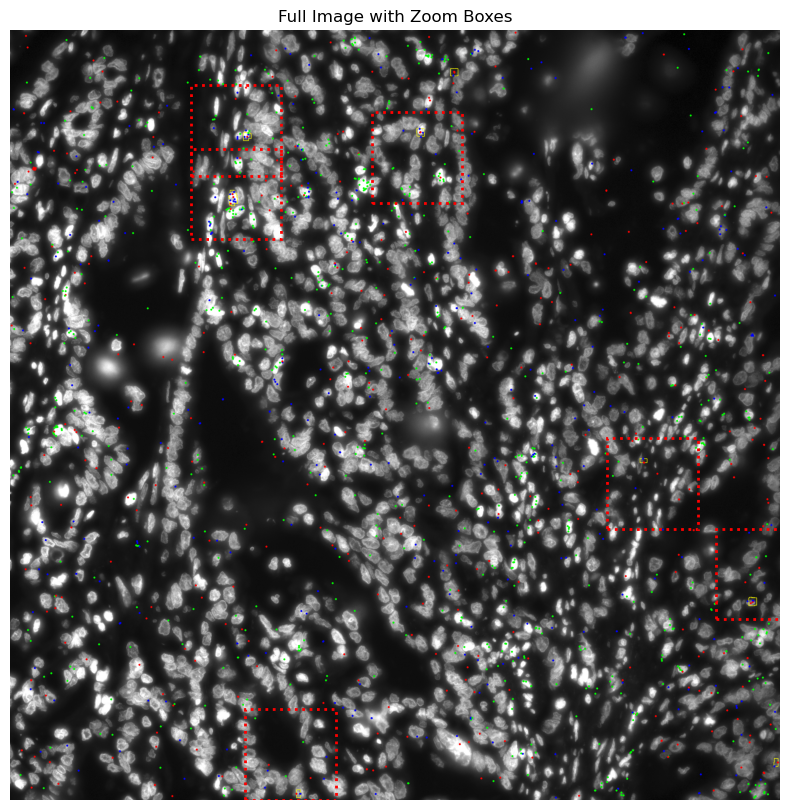

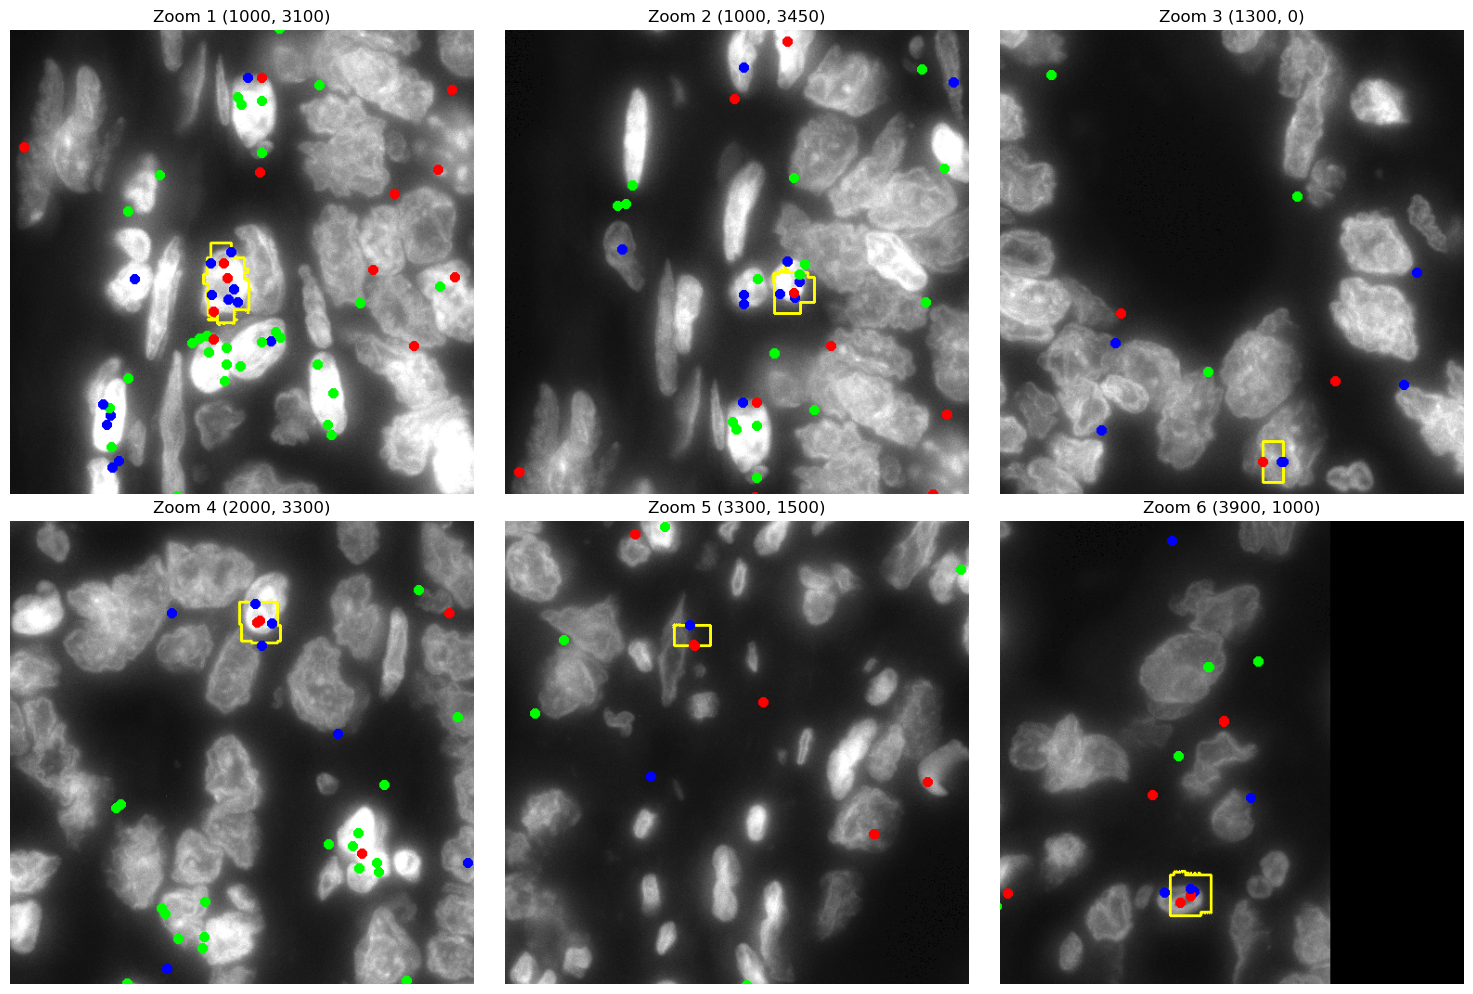

In [12]:
zoom_coords = [(1000,3100), (1000,3450), (1300,0), (2000,3300), 
              (3300,1500),(3900,1000)]
                    
zoom_size = 500  # size of the square to crop

# Plot full image with red rectangles ===
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_gd_contour, origin='lower')
ax.axis('off')
ax.set_title("Full Image with Zoom Boxes")

# Add red dotted rectangles
for zoom_x, zoom_y in zoom_coords:
    rect = patches.Rectangle(
        (zoom_x, zoom_y),
        zoom_size,
        zoom_size,
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        linestyle='dotted'
    )
    ax.add_patch(rect)

plt.show()

# Plot zoomed-in regions in a grid with 3 columns ===
num_coords = len(zoom_coords)
num_cols = 3
num_rows = (num_coords + num_cols - 1) // num_cols  # ceil division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

# If axes is 1D (single row), make it 2D for uniformity
if num_rows == 1:
    axes = [axes]

for idx, (zoom_x, zoom_y) in enumerate(zoom_coords):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row][col] if num_rows > 1 else axes[col]

    # Define bounding box for cropping
    box = (zoom_x, zoom_y, zoom_x + zoom_size, zoom_y + zoom_size)
    cropped_img = img_gd_contour.crop(box)

    ax.imshow(cropped_img, origin='lower')
    ax.axis('off')
    ax.set_title(f"Zoom {idx + 1} ({zoom_x}, {zoom_y})")

# Hide any unused subplots
for idx in range(num_coords, num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row][col] if num_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# fov = 'FOV006'